In [1]:
import numpy as np
from numpy import linalg as LA
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D

from PIL import Image
from scipy.optimize import minimize
import f_class
from GP import GP
from GP_grad import GP_grad
from GD import GD
import time
import imageio
from torch.quasirandom import SobolEngine
import sobol_seq
from utils import *

#### Noiseless & Noisy

In [2]:
Noise = False # Specify if noisy or not
Noise_level = 0.00 # if noisy, what is the noise sd
'''If use the scaled X and Y, rememeber to scale the noise as well'''

'If use the scaled X and Y, rememeber to scale the noise as well'

#### High-dimensional function $f$

In [3]:
objective = f_class.Hartmann_6(Noise, Noise_level)
# objective = f_class.Alpine(Noise, Noise_level) 
# objective = f_class.Ackley(Noise, Noise_level)
# objective = f_class.Michalewicz(Noise, Noise_level)
# objective = f_class.Schwefel(Noise, Noise_level, dim=20)
# objective = f_class.Rosenbrock(Noise, Noise_level)
# objective = f_class.Griewank(Noise, Noise_level)
objective = f_class.Levy(Noise, Noise_level, dim=10)  
objective = f_class.Rastrigin(Noise, Noise_level, dim=10)

f = objective.func
clean_f = lambda x: f_class.Hartmann_6().func(x)
# clean_f = lambda x: f_class.Alpine().func(x)
# clean_f = lambda x: f_class.Ackley().func(x)
# clean_f = lambda x: f_class.Michalewicz().func(x)
# clean_f = lambda x: f_class.Schwefel(dim=20).func(x)
# clean_f = lambda x: f_class.Rosenbrock().func(x)
# clean_f = lambda x: f_class.Griewank().func(x)
clean_f = lambda x: f_class.Levy(dim=10).func(x)
clean_f = lambda x: f_class.Rastrigin(dim=10).func(x)
B = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
print(B) 
lb = B[:, 0]; ub = B[:, 1]


dim = objective.input_dim
print('dim: ', dim)
print(f( np.array([dim*[0], dim*[0]])))

[[-5.12  5.12]
 [-5.12  5.12]
 [-5.12  5.12]
 [-5.12  5.12]
 [-5.12  5.12]
 [-5.12  5.12]
 [-5.12  5.12]
 [-5.12  5.12]
 [-5.12  5.12]
 [-5.12  5.12]]
dim:  10
[0. 0.]


#### Finding Optimized Hyperparameter $\sigma, \ell \rightarrow$ Online Update of Hyperparameter

In [4]:
# set seed
seed = 0
def random_draw(n_random_draws=3):
    """ samples some points"""
    # should draw randomly
    return np.random.uniform(lb, ub, size=(n_random_draws, dim))


def optimize_hyper(lb, ub, sample_size=2000):
#     np.random.seed(seed)
    X = np.asarray(np.random.uniform(lb, ub, size=(sample_size, dim)))
    gp.set_data(X, f(X))
    ls, var = gp.optimize()
    gp.clear()
    return (ls, var)

In [5]:
# # find optimized hyper, if online, skip this part
# gp = GP_grad(B, Noise, Noise_level)
# (ls, var) = optimize_hyper(lb, ub, sample_size=2000)
# del gp
# (ls, var)

#### Sampling

In [6]:
def unique_row(X):
    """
    A functions to trim repeated rows that may appear when optimizing.
    :param X: array to trim repeated rows from
    :return: mask of unique rows
    """
    # Sort array and kep track of where things should go back to
    order = np.lexsort(X.T)
    reorder = np.argsort(order)

    X = X[order]
    diff = np.diff(X, axis=0)
    U = np.ones(len(X), 'bool')
    U[1:] = (diff != 0).any(axis=1)
    return U[reorder]

class close_data():
    def __init__(self, Xc, eps=1):
        self.Xc = Xc
        self.eps = eps
        
    # Iterable
    def __iter__(self):
        return self
    
    # Iterator
    def __next__(self):
        Xn = self.Xc + self.eps*np.random.uniform(-1, 1, self.Xc.shape)
        return Xn
    
def is_new(Xn, Xpast=None):
    if Xpast is None:
        return True
    else:
        return np.array([(i != Xn).any() for i in Xpast]).all()

def close_draw(Xc, n_random_draws=4, close=1, Xpast=None):
    # sample from a small 2d box with center given Xc, no repeated points
    X = np.zeros((n_random_draws, dim))
    X[0] = Xc
    counter = 0
    gc = close_data(Xc)
    while True:
        Xn = next(gc)
        if LA.norm(Xn - Xc) > 5e-2 and is_new(Xn, Xpast) == True:
            counter += 1
            X[counter] = Xn
        if counter == n_random_draws-1:
            break
    return X

### Grid

In [7]:
# n_Grid = dim
# G = np.zeros((dim, n_Grid))
# for i in range(dim):
#     G[i] = np.linspace(lb[i], ub[i], n_Grid)

# Grid = np.vstack( [axis.flatten() for axis in np.meshgrid(*(G[i] for i in range(G.shape[0])))] ).T
# Grid.shape

### Grid Approx Gradient

In [8]:
# # approximate the gradient
# from scipy import optimize

# eps = np.sqrt(np.finfo(float).eps)
# approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
# approx_grad.shape

In [9]:
# # 3d plot of the gradient
# # approximate the gradient
# from scipy import optimize

# # optimize.approx_fprime(x, clean_Ackley_1d, eps)
# eps = np.sqrt(np.finfo(float).eps)
# approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
# approx_grad.shape
# g1 = approx_grad[:, 0]
# g2 = approx_grad[:, 1]
# g1, g2

# BO

In [10]:
MAX = 200 # function observations

## Gradient-based Method

##### 1. Setup

In [11]:
# initial data
setup = 1
X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))

# sample from a small 2d box
# Xc = np.asarray(np.random.uniform(lb, ub, size=(1, dim)))
# X = close_draw(Xc, n_random_draws=setup)

# X = np.vstack([X, np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))])

In [12]:
gp = GP_grad(B, Noise, Noise_level)
# gp.set_hyper(ls, var)  # if online, skip

gp.set_data(X, f(X))
ls, var = gp.optimize()
gp.set_hyper(ls, var)
gp.fit()

# w: starting point of GD
w = X[0].reshape(1, dim)
history_w = []
history_f = []

##### 2. Warm up

In [13]:
# gp.posterior_full_grad('full', dim*[w]), gp.posterior_grad(w)
# warmup = 30
# history_warmup = []
# for i in range(1, warmup+1):
#     b = np.log(i)
#     w, fw = gp.ucb_minimize(b)
#     X = np.vstack([X, w])
    
#     print(i, end = ', ')
#     print('w: ', w, end = ', ')
#     print('f(w): ', f(w).item(), end = ', ')
#     print()
    
#     gp.add_data(w.reshape(1, dim), f(w))
    
#     if i % 5 == 0:
#         ls, var = gp.optimize()
#         print('  # Optimal (ls, var) = ', (ls, var))
#     gp.fit()
#     history_warmup.append( (w, f(w)) )
    
# X_fix = X

In [14]:
# gp.posterior_full_grad('full', dim*[w]), gp.posterior_grad(w)
warmup = 10
history_warmup = []
for i in range(1, warmup+1):
    seed = np.random.randint(int(1e6))
    sobol = SobolEngine(dim, scramble=True, seed=seed)
    n_Grid = 10000
    Grid = np.array(sobol.draw(n_Grid))
    Grid = from_unit_cube(Grid, lb, ub)
    mu, covar = gp.posterior(Grid)
    mu = np.squeeze(mu)
    s = np.sqrt(np.diag(covar))

    L = np.linalg.cholesky(covar + 1e-6*np.eye(n_Grid)) # LL^T = Sigma (posterior covariance)
    f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_Grid, 1)))
    arg_min = np.argmin(f_post)
    w = Grid[arg_min]
    gp.add_data(w.reshape(1, dim), f(w))
    if i % 5 == 0:
        ls, var = gp.optimize()
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()    
                
    X = np.vstack([X, w])
    print(i, end = ', ')
    print('w: ', w, end = ', ')
    print('f(w): ', f(w).item(), end = ', ')
    print()
    history_warmup.append( (w, f(w)) )
    
X_fix = X

1, w:  [-1.544646    5.05386047  5.00318726  3.2134259  -0.06604736 -1.70598541
 -0.67389038  5.07851501 -2.78180145  3.02628235], f(w):  174.76751587561668, 
2, w:  [ 0.48606323 -4.33446198  0.64332764 -2.12126556  0.66401367  4.02737305
  2.61971985 -4.83821743 -0.67360291 -2.08178497], f(w):  182.8956723662811, 
3, w:  [ 2.77902893  2.07559326 -1.61645477  2.35244751 -0.21197357 -4.7692173
 -4.17065849 -0.78662262 -3.68560669 -1.70858765], f(w):  176.0955510002349, 
4, w:  [ 2.2481488  -1.18205414  2.30450745 -1.3220224  -3.42445114  0.6609491
  3.43080688  4.85201843  3.26250366 -3.4299585 ], f(w):  213.99232441194317, 
  # Optimal (ls, var) =  (10.0, 13161.824637880307)
5, w:  [-4.21037247 -1.82414948  2.95492798 -3.82527206 -3.28699692 -4.63824379
 -4.60611382  4.62243408 -1.92203217  1.54350403], f(w):  228.89331883760366, 
6, w:  [ 4.49510803  0.29123474 -3.21289383  2.85174072 -4.13881729 -2.57122162
 -2.89837448 -4.98013806  3.33774353  4.55574036], f(w):  231.12847106349813,

##### 3. Optimize via GD

In [15]:
w = gp.X[np.argmin(gp.y)]
optimizer = GD(gp, B, w, f)

from scipy import optimize
eps = np.sqrt(np.finfo(float).eps)
gp.grad(w), gp.grad_sample(w), optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps)

(array([[-6.78534006,  6.32070295,  7.79543072, -0.60412617, -5.78900552,
          3.62887553, -1.59231393,  7.1287169 , -7.26214166, 14.94926766]]),
 array([[  0.07789937,   9.36283096,  17.38828915,   5.82514497,
           0.81378202,   6.50688827,  22.26031078, -13.20725014,
         -11.73901652,  15.51892661]]),
 array([ 14.93450356, -65.41067123,  29.91214943, -36.27131653,
         44.26212692,  44.87620544, -62.5789814 , -33.43266106,
        -52.10484123,  52.45316315]))

In [16]:
gp.optimize()
np.set_printoptions(precision=4)
stall = False
cost = setup + warmup

desc = -optimizer._grad()

lr = 0.05
while cost <= MAX:
    # update w 
    if optimizer.contFail >= 7 or stall:
        lr = 0.05
        print()
        print('New Local Search: ',)
        print('Fail = ', optimizer.contFail, end = ', ')
        print('Norm = ', LA.norm(desc))
        
#         # 1. random draw
#         w = np.asarray(np.random.uniform(lb, ub, size=(1, dim)))
        
#         2. UCB draw
#         w, _ = gp.ucb_minimize(cost)
#         gp.add_data(w.reshape(1, -1), f(w))
        
        # many UCB draws, pick the best
#         history_warmup = []
#         alternate = 30
#         for i in range(1, alternate+1):
#             b = np.log(i)
#             w, fw = gp.ucb_minimize(b)
#             if i == 1:
#                 X = w
#             else:
#                 X = np.vstack([X, w])

# #             print(i, end = ', ')
# #             print('w: ', w, end = ', ')
# #             print('f(w): ', f(w).item(), end = ', ')
# #             print()

#             gp.add_data(w.reshape(1, dim), f(w))
#             if i % 5 == 0:
#                 ls, var = gp.optimize()
#                 print('  # Optimal (ls, var) = ', (ls, var))
#             gp.fit()
#             history_warmup.append( (w, f(w)) )

#         w = X[np.argmin(f(X))]
        
        # thompson sampling
        ts_alternate = 10
        for i in range(0, ts_alternate):
            seed = np.random.randint(int(1e6))
            sobol = SobolEngine(dim, scramble=True, seed=seed)
            n_Grid = 10000
            Grid = np.array(sobol.draw(n_Grid))
            Grid = from_unit_cube(Grid, lb, ub)
            mu, covar = gp.posterior(Grid)
            mu = np.squeeze(mu)
            s = np.sqrt(np.diag(covar))

            L = np.linalg.cholesky(covar + 1e-6*np.eye(n_Grid)) # LL^T = Sigma (posterior covariance)
            f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_Grid, 1)))
            arg_min = np.argmin(f_post)
            w = Grid[arg_min]
            gp.add_data(w.reshape(1, dim), f(w))
            if i % 5 == 0:
                ls, var = gp.optimize()
                print('  # Optimal (ls, var) = ', (ls, var))
            gp.fit()
            if i == 0:
                X = w
            else:
                X = np.vstack([X, w])
                   
        w = X[np.argmin(f(X))]

#         if is_new(w, gp.X) == False:
#             raise ValueError('  ?? hit past points')
        
#         gp.add_data(w.reshape(1, -1), f(w)) 
        
        # change back setting
        cost += ts_alternate
        stall = False
        
        history_w.append(optimizer.history_w)
        history_f.append([f(w).item() for w in optimizer.history_w])
        optimizer = GD(gp, B, w, f)
    else:
        lr = lr
        w, desc = optimizer.update_sample(y_best=np.min(f(gp.X)), lr=lr)
        if is_new(w, gp.X) == False:
            print('  ** hit past points')
            stall = True
            continue
            
        gp.add_data(w.reshape(1, -1), f(w))
        cost += 1
    
    
    # online hyper udpate + fitting GP with new query w
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()

    m, v = gp.posterior_full_grad('full', dim*[w])
    v = np.sqrt(np.diag(v))
    print(cost, end = '. ')
    print('    w: ', np.squeeze(w), end = ', ')
    print('    f(w): %.6f ' % f(w).item())
    print('       d(w): ', np.squeeze(m))
    print('       s.d: ', np.squeeze(v))
    print('       g(w):', optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps))
    print('       lr: %.4f' % lr)
    print()
        
print('Max Cost reached = ', cost)
history_w.append(optimizer.history_w)
history_f.append([f(w).item() for w in optimizer.history_w])

GD loop:  0
consecutive fail:  1
  # Optimal (ls, var) =  (10.0, 16287.484046288457)
12.     w:  [ 3.0292 -2.2879 -2.9274 -0.0917  3.1009 -1.6366 -0.2453 -2.0837  4.7673
 -4.758 ],     f(w): 148.158387 
       d(w):  [-6.7321  6.3152  7.6139 -0.5488 -5.8445  3.7053 -1.7546  7.0929 -7.3837
 14.6389]
       s.d:  [11.9549 11.5326 10.2937 11.8169 10.478  10.8816 10.0434 10.2842  9.278
  7.6195]
       g(w): [ 17.5329 -65.6322  21.8277 -34.4049  43.4062  44.2834 -63.2951 -35.7093
 -52.9243  53.2363]
       lr: 0.0500

GD loop:  0
consecutive fail:  2
13.     w:  [ 3.0578 -2.2887 -2.9164 -0.0982  3.1073 -1.6249 -0.2562 -2.0732  4.7854
 -4.786 ],     f(w): 148.071959 
       d(w):  [-0.2514  6.8026 12.239  -3.0771 -4.4825  6.2946 -3.1273  8.99   -4.2065
 11.6564]
       s.d:  [ 9.573  11.526   8.9313 11.4812 10.3787 10.5038  9.9304 10.0702  8.6087
  6.8814]
       g(w): [ 28.4416 -65.5574  25.6751 -36.5576  45.444   41.1505 -63.296  -32.0508
 -51.7102  51.6612]
       lr: 0.0500

GD loop:  0

GD loop:  0
consecutive fail:  0
  # Optimal (ls, var) =  (1.5100572708821323, 40107.50467493392)
30.     w:  [ 2.9993 -2.1636 -2.9713 -0.016   3.0047 -1.7393  0.0174 -1.9637  4.9452
 -4.9418],     f(w): 104.579537 
       d(w):  [ 30.132  -41.9228  17.3498  -6.2324  27.3083  50.7576  -4.4781  -8.049
  -7.6254  -4.832 ]
       s.d:  [16.2458 26.4623 13.0421 18.1391 16.1097 18.0822 22.2836 18.4434  8.8971
 17.718 ]
       g(w): [  5.7163 -58.1177   5.3242  -6.3216   7.8721  59.2113   6.8993  10.295
 -11.3073  12.5819]
       lr: 0.0500

GD loop:  0
consecutive fail:  0
31.     w:  [ 2.9802e+00 -2.1507e+00 -2.9813e+00 -3.4974e-03  2.9823e+00 -1.7653e+00
  3.8894e-02 -1.9645e+00  4.9526e+00 -4.9464e+00],     f(w): 102.220411 
       d(w):  [ 19.2746 -62.5923  22.7623  13.668   22.2565  38.5549  25.7549 -19.6169
  -0.2316  -3.7469]
       s.d:  [16.4107 24.2526 14.8614 14.9974 17.8632 18.3613 18.03   18.3452 10.5436
 19.6412]
       g(w): [ -1.8551 -55.3045   1.4179  -1.3876  -1.014   59.0

GD loop:  0
consecutive fail:  4
58.     w:  [ 0.0555  1.3334  0.077   2.566  -1.0789  2.0768 -1.6379  1.7268 -4.9423
 -1.4002],     f(w): 130.827859 
       d(w):  [ -9.6248 -11.5809   0.9363 -13.3578   7.6791  13.4735  41.1225 -26.3926
 -17.8645  -3.6636]
       s.d:  [189.1184 188.9664 209.1926 186.5051 154.1224 188.3908 101.7223 166.8922
  59.5401 170.7096]
       g(w): [ 21.5936  57.0639  29.375  -20.2012 -32.058   33.31    44.6031 -58.7126
  12.3977 -39.6659]
       lr: 0.0500

GD loop:  0
consecutive fail:  5
59.     w:  [ 0.0348  1.3045  0.1059  2.5778 -1.0761  2.0818 -1.6515  1.7284 -4.9364
 -1.3992],     f(w): 128.867969 
       d(w):  [  6.1993  10.1782 -20.1657 -21.2275   5.1319   9.114   49.27   -26.1484
 -22.2552  -4.3978]
       s.d:  [164.431  138.692  168.3509 180.7888 153.449  186.6182  90.4045 166.9387
  54.0162 170.7092]
       g(w): [ 13.6834  61.7973  39.0048 -24.3387 -31.0624  35.0658  47.8678 -58.7982
  14.5773 -39.9706]
       lr: 0.0500

GD loop:  0
consecutiv

  # Optimal (ls, var) =  (1.4654369103870628, 89720.30081511682)
93.     w:  [ 2.0002 -2.8152 -1.9745 -2.2345 -3.2988 -3.4025  2.7653  1.2857 -2.9127
  1.1423],     f(w): 135.201591 
       d(w):  [ 22.6797  -3.6495   4.5543 -24.1949 -61.321  -25.327  -14.5309  42.7734
  58.1051  60.2341]
       s.d:  [182.5399 153.8478 149.1292 150.8798 173.3305 100.6211 179.2213  96.3046
 133.8041  88.7204]
       g(w): [  4.0773  52.0001   6.0789 -67.0035 -66.5043 -42.9427 -57.0103  63.8268
  26.9324  51.2637]
       lr: 0.0500

GD loop:  0
consecutive fail:  6
94.     w:  [ 2.0118 -2.8027 -1.9849 -2.2364 -3.294  -3.391   2.7285  1.2959 -2.9245
  1.1237],     f(w): 136.747780 
       d(w):  [ 37.5641   9.6758  -6.7973 -28.6436 -61.8734 -14.7893 -56.9769  58.0299
  50.137   45.9278]
       s.d:  [173.9126 145.5018 142.9859 150.0725 173.3573  92.5102  82.5004  78.1121
 130.2729  70.0293]
       g(w): [  8.683   53.8148   1.9759 -67.075  -67.0289 -46.5149 -56.8035  62.8237
  22.8521  46.3076]
       lr

GD loop:  0
consecutive fail:  0
119.     w:  [ 3.0231  3.9192 -4.1235 -2.0503 -0.9612 -1.7532 -2.0244  2.9699 -2.0547
 -1.8105],     f(w): 92.109366 
       d(w):  [ 14.0381 -24.1081 -55.3855  -4.6802  33.0475  37.7332  -8.3711  13.5161
 -41.539   46.8844]
       s.d:  [28.3535 33.2619 26.7956 40.3366 27.1371 32.2764 19.9058 39.2728 23.7615
 33.9848]
       g(w): [ 15.1439 -22.7116 -52.2488 -23.6242  13.257   59.3129 -13.6265  -5.8533
 -25.2941  54.7195]
       lr: 0.0500

GD loop:  0
consecutive fail:  0
  # Optimal (ls, var) =  (1.5538110302200778, 95649.25361318223)
120.     w:  [ 3.0175  3.9221 -4.1114 -2.075  -0.9706 -1.7757 -2.014   2.9814 -2.04
 -1.8361],     f(w): 88.777276 
       d(w):  [ 10.8125 -22.8807 -53.8753  -7.5866  30.3206  35.5551  -2.6985  16.7633
 -39.1086  43.8557]
       s.d:  [32.1154 37.1812 29.0652 29.214  29.821  35.6238 22.4911 37.4596 26.1026
 36.2614]
       g(w): [ 12.944  -21.7133 -48.6828 -32.6576   9.5885  58.4624  -9.5473  -1.3496
 -19.723   50.1877

GD loop:  0
consecutive fail:  7
136.     w:  [ 2.9562  3.9678 -4.0145 -2.0045 -0.9662 -2.0199 -1.9665  2.9618 -1.9614
 -1.99  ],     f(w): 71.825768 
       d(w):  [ -6.9637 -13.2005  -7.84    -6.9201   4.0757  -6.3359   2.3953   8.7984
  15.6038  13.5086]
       s.d:  [10.1594 17.1533 13.6676 12.0261 17.0963  8.407  12.6481 16.6643 17.3282
 12.9437]
       g(w): [-11.1599  -4.6842 -13.7648  -5.789   11.3222 -11.8626   9.1964  -9.012
  11.1697  -0.0255]
       lr: 0.0500


New Local Search: 
Fail =  7, Norm =  40.64468347924079
  # Optimal (ls, var) =  (1.3302389164257362, 53029.70955341647)
  # Optimal (ls, var) =  (1.3230724037121349, 51761.193428868006)
146.     w:  [-2.8553 -2.1269  3.1385 -0.8255 -1.2193  1.6702  2.9685 -1.2292 -1.2125
 -2.738 ],     f(w): 112.830570 
       d(w):  [-0.0005  0.0007 -0.0028  0.0011 -0.0008 -0.0014  0.0008  0.0031 -0.0021
 -0.0018]
       s.d:  [171.9565 171.9565 171.9565 171.9565 171.9565 171.9565 171.9565 171.9565
 171.9565 171.9565]
       g(w):

  # Optimal (ls, var) =  (1.3711270352885243, 54780.55260477596)
162.     w:  [-2.9584 -1.9968  2.9814 -0.9747 -1.104   1.7332  2.9922 -1.0345 -1.0529
 -2.8646],     f(w): 63.984509 
       d(w):  [ 16.2394 -16.3063  10.7079  11.5979 -48.7162 -53.2445  12.55   -12.3499
 -23.1456  35.586 ]
       s.d:  [35.5929 26.4196 24.1969 20.456  28.8558 22.6876 22.3324 29.6833 30.538
 23.9365]
       g(w): [ 10.3134  -2.7336  -1.3822   7.9983 -40.393  -59.015    2.9061 -15.5653
 -22.6073  41.4935]
       lr: 0.0500

GD loop:  0
consecutive fail:  0
163.     w:  [-2.9571 -1.9718  2.9533 -0.9791 -1.0947  1.7605  2.98   -1.0413 -1.055
 -2.8586],     f(w): 62.650949 
       d(w):  [ 14.0924   0.2291  -4.4174   4.0552 -48.9311 -47.3591  10.1418 -21.245
 -27.8697  48.1381]
       s.d:  [38.5701 22.1817 21.3255 22.5194 31.6739 23.7352 24.8876 28.8732 32.1586
 14.4126]
       g(w): [ 10.8345   7.1496 -12.2476   6.2598 -37.4128 -59.1749  -1.9108 -18.2058
 -23.3996  43.0407]
       lr: 0.0500

GD loop:  0
c

  # Optimal (ls, var) =  (1.2166652633567778, 37821.03457453035)
  # Optimal (ls, var) =  (1.4817663564502968, 94115.84238051166)
  # Optimal (ls, var) =  (0.9232513719475052, 11021.31132628557)
189.     w:  [ 0.6131  1.6571  0.0731  2.6331 -0.152   0.3177 -0.652   4.2859 -0.0543
 -5.0123],     f(w): 151.914456 
       d(w):  [-1.6649e-11  5.6845e-12  1.4497e-12  2.5329e-12 -2.1286e-11  4.8680e-11
 -1.3178e-11 -8.5519e-11 -1.6013e-10  1.1165e-10]
       s.d:  [113.7095 113.7095 113.7095 113.7095 113.7095 113.7095 113.7095 113.7095
 113.7095 113.7095]
       g(w): [-39.7557 -49.1109  28.0163 -41.3629 -51.6062  57.8625  49.9844  69.8096
 -21.1488 -14.8837]
       lr: 0.0500

GD loop:  0
consecutive fail:  1
190.     w:  [ 0.6164  1.6377  0.0736  2.6476 -0.1343  0.3015 -0.6686  4.2937 -0.0521
 -5.0437],     f(w): 150.535189 
       d(w):  [ -2.1415  12.4028  -0.2997  -9.3068 -11.3615  10.3574  10.6218  -5.0014
  -1.4516  20.0598]
       s.d:  [113.4549 104.8331 113.7045 108.8006 106.3111 

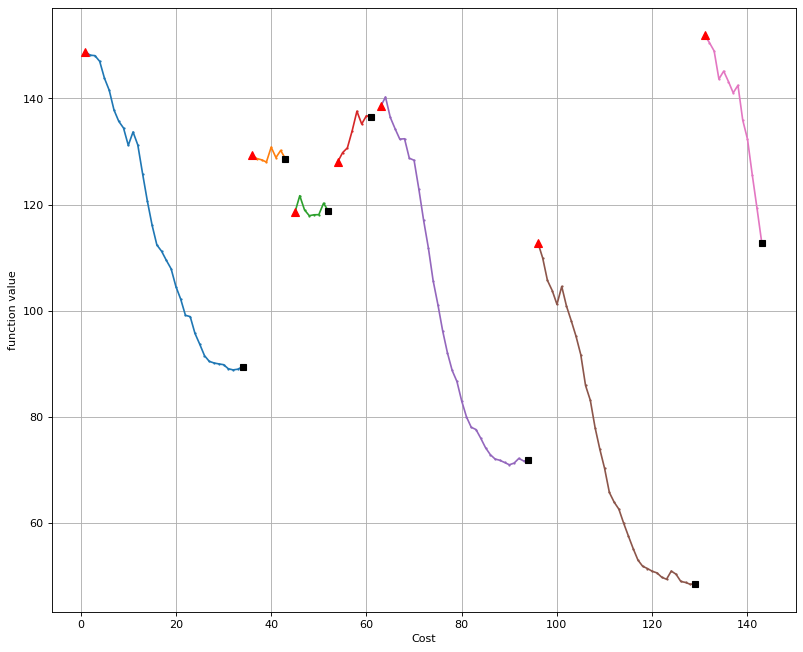

In [17]:
pl.figure(figsize=(12, 10), dpi=80)
axis = 1
for l in history_f:
    pl.plot(np.arange(axis, axis+len(l)), l, "-o", markersize=1)
    pl.plot(axis, l[0], "r^", markersize=8)
    pl.plot(axis+len(l)-1, l[-1], "ks")
    axis += len(l) + 1 # COST includes setup


pl.plot()

pl.xlabel("Cost")
pl.ylabel("function value")
pl.grid(True)

## Minima of GD

In [18]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

(array([-3.0174, -1.98  ,  3.0147, -1.0186, -0.9758,  1.9818,  2.971 ,
        -1.0044, -0.9755, -2.978 ]),
 48.498661020077115,
 177)

In [19]:
gp.get_hyper()

{'var': 68396.08007640725, 'lengthscale': 1.4041603843339117}

In [20]:
# # only for backtracking
# pl.figure(figsize=(10, 6), dpi=80)
# # pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

### *Thompson Sampling, UCB*

In [21]:
### Thompson Sampling
import os
gp.clear()
# gp.set_hyper(ls, var) # if online update hyper, skip

# init cost
X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
X = X_fix

gp.set_data(X, f(X))
gp.optimize()
gp.fit()

history = [(w, f(w)) for w in X]

In [22]:
cost = setup + warmup
while cost < MAX:
    # posterior of GP given gp.X, gp.y
    mu, covar = gp.posterior(Grid)
    mu = np.squeeze(mu)
    s = np.sqrt(np.diag(covar))
    
    # posterior of GP derivative given gp.X, gp.y
    # partial x1
#     gp.set_p(0)
#     mu_grad_1, covar_grad_1 = gp.posterior_grad(Grid)
#     mu_grad_1 = np.squeeze(mu_grad_1)
#     s_grad_1 = np.sqrt(np.diag(covar_grad_1))

#     # partial x2
#     gp.set_p(1)
#     mu_grad_2, covar_grad_2 = gp.posterior_grad(Grid)
#     mu_grad_2 = np.squeeze(mu_grad_2)
#     s_grad_2 = np.sqrt(np.diag(covar_grad_2))
    
    # 1. Thompson Sampling
    n_Grid = 10000
    seed = np.random.randint(int(1e6))
    sobol = SobolEngine(dim, scramble=True, seed=seed)
    Grid = np.array(sobol.draw(n_Grid))
    Grid = from_unit_cube(Grid, lb, ub)
    L = np.linalg.cholesky(covar + 1e-6*np.eye(n_Grid)) # LL^T = Sigma (posterior covariance)
    f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_Grid, 1)))
    arg_min = np.argmin(f_post)
    w = Grid[arg_min]
    
    # 2. GP_UCB
#     b = np.log(cost)
#     arg_min = np.argmin(mu.reshape(-1,1) - np.sqrt(b)*s.reshape(-1, 1)) # discrete version
#     w = Grid[arg_min]
#     w, fw = gp.ucb_minimize(b)
#     w, fw = gp.EI_minimize(y_best=np.min(f(gp.X)))
    if is_new(w, gp.X) == False:
        print('visit before, ignore ', w)
        continue
    
    
#     fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(24, 21))

#     # plot function (ax1, ax2)
#     im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax2)

#     im1 = ax1.contour(X1, X2, functions.Ackley_2().func(Grid).reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax1)
#     fig.colorbar(im2, ax=ax1)

#     ax1.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax1.plot(w[0], w[1], 'ro')
#     ax1.title.set_text("Noisy Ackley")
#     ax2.title.set_text("Standard Deviation")
    
    
#     # plot derivative in (ax3, ax4), (ax5, ax6)
#     im = ax4.pcolormesh(X1, X2, s_grad_1.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax4)
#     im1 = ax3.contour(X1, X2, g1.reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax3.contour(X1, X2, mu_grad_1.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax3)
#     fig.colorbar(im2, ax=ax3)

#     ax3.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax3.title.set_text("Mean of Posterior Partial x")
#     ax4.title.set_text("Std of Posterior Partial x")

    
#     im3 = ax6.pcolormesh(X1, X2, s_grad_2.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im3, ax=ax6)
#     im4 = ax5.contour(X1, X2, g2.reshape(X1.shape), cmap="PuBuGn")
#     im5 = ax5.contour(X1, X2, mu_grad_2.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im4, ax=ax5)
#     fig.colorbar(im5, ax=ax5)

#     ax5.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax5.title.set_text("Mean of Posterior Partial y")
#     ax6.title.set_text("Std of Posterior Partial y")

#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     pl.savefig('2D_Plots/Ackley/' + filename)
#     pl.show()  
    print(cost, end = '. ')
    print('w: ', w)
    print('  f(w): ', f(w).item())
    print()
    
    history.append( (w, f(w)) )
    gp.add_data(w.reshape(1, dim), f(w))
    
    if cost % 10 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    cost += 1

11. w:  [-1.7824 -2.0018  2.4114  4.6548  0.7318  1.8316  3.9453  0.6477 -2.7541
  1.3555]
  f(w):  164.7732384751232

12. w:  [ 3.4428  1.8475  3.8658 -1.2541  3.2037  4.756  -4.6164  4.2122 -0.4111
 -1.1901]
  f(w):  209.1738294218899

13. w:  [-3.608  -2.1735 -0.8011  3.8546 -3.2394 -4.1883 -2.7865  1.4223  4.163
  2.2246]
  f(w):  182.56495771849563

14. w:  [ 0.2807  3.2092 -1.7821  3.9509  3.265  -1.7374 -1.6872 -1.1192  3.8104
  3.2655]
  f(w):  155.50102304755583

15. w:  [-4.0345 -2.117   0.2044  4.6138  2.9393 -2.5299 -4.1981  3.2203  3.9762
  3.7735]
  f(w):  186.83097918211558

16. w:  [-0.404   0.7227  1.7898 -5.0531  4.4751 -1.2022  3.6827 -0.0613 -0.0407
  0.0188]
  f(w):  144.6326487911968

17. w:  [-3.7875 -1.5073  2.5393  4.6407 -1.0221 -3.8799 -2.4592  5.0005 -0.2436
 -2.2247]
  f(w):  200.95612124215072

18. w:  [-2.2235  3.799   0.2472 -2.5172 -4.1707  2.0047 -3.5431 -1.4474  1.4995
  0.6457]
  f(w):  189.99124909693091

19. w:  [-0.0175 -1.2938  2.2745 -2.2765 -2.

77. w:  [ 4.2331 -1.2146 -2.5107 -1.768   4.0959 -1.4284 -1.6552  0.4446  0.8772
  3.4034]
  f(w):  185.3375364542076

78. w:  [ 4.5735  1.8857  4.3644  4.6782  2.4821 -0.2555  3.8239 -2.6031  2.1466
 -4.3086]
  f(w):  239.90039897932658

79. w:  [-3.6421  3.5766 -1.498  -4.2249 -3.2895  3.0688 -4.3947  0.1512 -1.0175
  2.0716]
  f(w):  191.11965296561772

80. w:  [ 3.1524  3.7548  0.1748  2.9649  2.8689  0.7042 -1.7955  3.9774  2.9113
 -0.7123]
  f(w):  126.42463323272887

  # Optimal (ls, var) =  (10.0, 17006.041316391136)
81. w:  [-4.2214  2.4471  1.4715 -2.6069 -2.2521  3.981   1.6409  4.7062  1.7695
  2.5728]
  f(w):  220.61768963355746

82. w:  [-1.3441 -2.4481  3.8274  1.0118  2.5861 -2.5289 -0.4594 -1.6181  3.6502
 -3.4794]
  f(w):  216.45673312876886

83. w:  [-4.8243 -0.9283  0.306   2.4636 -4.6593 -3.0252  3.9407 -1.7524 -4.8796
 -3.3842]
  f(w):  200.96032919968707

84. w:  [ 2.2897  0.3     2.5622 -0.4792 -1.6894  4.7504  0.927  -2.1881  1.2898
  1.4694]
  f(w):  174.95376

143. w:  [-2.5515 -4.0382  1.6236 -0.4006  3.9074 -1.1285 -3.8668  2.3726  3.3056
 -2.4723]
  f(w):  193.05340226953686

144. w:  [ 3.4866  2.3972  0.0188  4.0034 -0.4022 -0.8244 -0.6123 -0.815   0.5413
 -3.2702]
  f(w):  163.06200744429069

145. w:  [-4.2792  2.9753 -4.7375 -3.2215  2.7282 -1.3373  3.971  -4.5588  0.5521
  3.5736]
  f(w):  234.2810578722048

146. w:  [ 4.1777  3.1851  0.5261 -0.4111  3.71   -1.8561 -4.2961  3.4367  4.259
  1.9968]
  f(w):  206.57983832663328

147. w:  [ 4.1504  3.2786  1.6632  0.8849  3.8696  5.0789  1.7939  0.1184 -1.3396
 -2.7863]
  f(w):  156.07595382244182

148. w:  [-4.45    3.186  -0.0643 -0.6562  0.151  -2.4183  4.6739  0.1849 -0.3464
 -0.5489]
  f(w):  179.247278053171

149. w:  [ 1.8633  1.3217 -3.6178  1.1927  2.3259  4.3666  1.3871  4.2368 -3.1946
  0.0648]
  f(w):  181.42015622762273

150. w:  [ 3.2936 -3.352   1.5694 -0.6317 -1.8802 -2.361  -4.0762 -2.506  -3.2149
 -3.476 ]
  f(w):  211.82490248409505

  # Optimal (ls, var) =  (9.61241436

<ipython-input-23-cec4f57979c1>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.squeeze(np.array(history)[:, 1]), "-^")


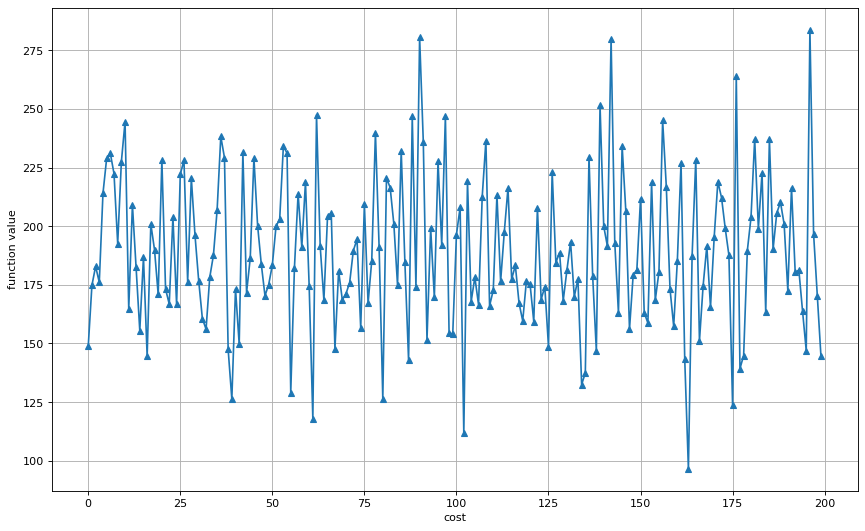

In [23]:
pl.figure(figsize=(13, 8), dpi=80)
pl.plot(np.squeeze(np.array(history)[:, 1]), "-^")
pl.xlabel("cost")
pl.ylabel("function value")
pl.grid(True)

## Global Minima 

In [24]:
gp.X[np.argmin(gp.y)], np.min(gp.y)

(array([ 1.008 , -1.1299, -4.6738, -0.1292, -1.3992, -0.1045, -0.7759,
         2.1544,  0.1868,  0.8418]),
 96.54949025446052)

In [25]:
gp.get_hyper()

{'var': 17387.184820787505, 'lengthscale': 9.449117716708418}